<a href="https://colab.research.google.com/github/sakuronohana/cas_datenanalyse/blob/master/Semesterarbeit/CAS_DA_SA_Payment_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img 
src="https://www.ffhs.ch/templates/ffhs/img/logo@2x.png" width="100"> 
###DaAn, Data Analysis, MAS/CAS Web4B 2018, ZH1, FS19, Dr. Tödtli Beat###

##*Semesterarbeit von Patrik Di Lena*##
#Betrugserkennung Zahlungsverkehr#



##Ziel##
Das Ziel dieser Semesterarbeit ist die Gegenüberstellung von Supervised und Unsupervised Lernverfahren mit eine neuronalen Netzwerk Algorthmus. Dabei kommt  ein nicht gelabelter und ein gelabelter Datensatz aus einem Betrugserkennungssystem zum Einsatz. 

##Aufgabenstellung##
###Erkennung von Betrugszahlungen###
Mittels Unsupervised Learning sollen Betrugszahlungen aus einem nicht gelabelten Datensatz erkannt und die Effiktivität des vorhandenen Fraud-Detection Systems geprüft werden.

###Betrugsanfällige Risikogruppen###
Mit Hilfe von Supervised Learning werden mögliche Risikogruppen ermittelt, welche im Visier von Betrügern stehen.  Auf Basis eines gelabelten Datensatzes  werden die Risikogruppen nach folgenden Merkmalen unterschieden:

*	Geschlecht
*	Alter
*	Zivilstand
*	Nationalität
*	Kontosaldo
*	Wohnort
*	Region

##Datensatz##
Die im Rahmen dieser Semesterarbeit verwendeten Daten entstammen, von ihrer Datenstruktur her, aus einem bereits eingesetzten nicht ML-basierten Betrugserkennungssystem. Die Datenwerte wurde zu Wahrung der datenschutzrechtlichen und bankengesetzlichen Aspekte mit Hilfe eines Python-Scripts künstlich erzeugt und beinhalten somit keine reale Zahlungs- oder Kunden-Informationen.   

Datenselektion:

- 20'800 synthetische Kunden (Vorname, Name, Strasse, Ort, Kanton, Sprachregion, Geschlecht, Alter, Zivilstand,  Nationalität, Kontonummer, Vertragsnummer, Rechtsform)

- 60'000 synthetische Zahlungen (Transaktionsid, ,Erstellungdatum/Zeit, Empfängerkonto, Empfängerbank, Empfängerland, Währung, Betrag, Valuta Datum)








#Erkennung von Betrugszahlungen# 

##Unsupervised Learning mit neuronalen Netzwerken##

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Laden der 600000 nicht gelabelten Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ol.csv'

trx_data_ol = pd.read_csv(trx_data_url, delimiter=';')
trx_data.head(-5)

#Ermittlung potenzieller Kundenrisikogruppen# 
##Supervised Learning mit neuronalen Netzwerken##


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Laden der 600000 Transaktionsdaten 
trx_data_url = 'https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/Semesterarbeit/Dataset/trx_data_ml.csv'

trx_data_ml = pd.read_csv(trx_data_url, delimiter=';')
trx_data.head(-5)



# Zuerst werden die Daten zentriert und scaliert
#scale_trx_data = preprocessing.scale(trx_data.T)

,timestamp,paym_id,send_bc_nr,amount,rcv_bc_nr,rcv_bc_iban,rcv_bc_country,rcv_bc_code,rcv_iban,valuta_date,cust_vertrag_nr,cust_konto_nr,cust_vname,cust_nname,cust_plz,cust_ort,cust_kanton,cust_sprachregion,cust_auth_device,fraud_id
0,01.01.18 08:00,10000010,CHBANK71XXX,15368,JOBANK40XXX,JO02SCBL1260000000018525836101,Jordanien,JO,JO40002096331755419,01.01.18 08:00,76311,CH5300772672529640195,Martin,Bader,6020,Emmenbrücke,LU,de,mtan,0
1,01.01.18 08:00,10000011,CHBANK71XXX,89137,STBANK68XXX,ST23000200000289355710148,Sao Tome und Principe,ST,ST68002492808312214,01.01.18 20:00,69891,CH5300772670061796126,Margaretha,Fehr,9056,Gais,AR,de,ptan,0
2,01.01.18 08:01,10000012,CHBANK71XXX,87673,XKBANK43XXX,XK051301001002074155,Kosovo,XK,XK43002422391264290,02.01.18 08:01,78573,CH5300772500037725234,Daniel,Miéville,1253,Vandoeuvres,GE,fr,ptan,0
3,01.01.18 08:01,10000013,CHBANK71XXX,55941,RSBANK72XXX,RS35105008054113238018,Serbien,RS,RS72002873180573624,02.01.18 20:01,75443,CH5300772732508635138,Andrea,Iseni,6026,Rain,LU,de,mtan,0
4,01.01.18 08:02,10000014,CHBANK71XXX,88173,LIBANK48XXX,LI0308800000022875748,Liechtenstein,LI,LI48002899580343897,03.01.18 08:02,73167,CH5300772640237288398,Andrea,Pinana,6693,Broglio,TI,it,mtan,0
5,01.01.18 08:02,10000015,CHBANK71XXX,80867,BABANK16XXX,BA391011606058553319,Bosnien und Herzegowina,BA,BA16002605320963848,03.01.18 20:02,78859,CH5300772172038822637,Peter,Häner,6006,Luzern,LU,de,ptan,0
6,01.01.18 08:03,10000016,CHBANK71XXX,71350,AZBANK13XXX,AZ04UBAZ04003214540060AZN001,Aserbaidschan,AZ,AZ13002171127282593,04.01.18 08:03,67397,CH5300772262693101243,Ursula,Derungs,6247,Schötz,LU,de,mtan,0
7,01.01.18 08:03,10000017,CHBANK71XXX,59621,MEBANK57XXX,ME25505120000000466170,Montenegro,ME,ME57002543853188821,04.01.18 20:03,67029,CH5300772511216015083,Michel,Kaenel,1665,Estavannens,FR,fr,ptan,0
8,01.01.18 08:04,10000018,CHBANK71XXX,88225,SEBANK70XXX,SE0230000000030301099952,Schweden,SE,SE70002263708184448,05.01.18 08:04,85757,CH5300772960799401160,Francesco,Lafranchi,6943,Vezia,TI,it,ptan,0
9,01.01.18 08:04,10000019,CHBANK71XXX,81564,NLBANK58XXX,NL02ABNA0457180536,Niederlande,NL,NL58002162620005224,05.01.18 20:04,71969,CH5300772221245992471,Thomas,Müller,6020,Emmenbrücke,LU,de,ptan,0


In [0]:
trx_data.nunique()

timestamp            30000
paym_id              60000
send_bc_nr               1
amount               45004
rcv_bc_nr               75
rcv_bc_iban             75
rcv_bc_country          75
rcv_bc_code             75
rcv_iban             59529
valuta_date          60000
cust_vertrag_nr      19591
cust_konto_nr        20800
cust_vname             417
cust_nname            4254
cust_plz               614
cust_ort               722
cust_kanton              6
cust_sprachregion        3
cust_auth_device         2
fraud_id                 3
dtype: int64

In [0]:
trx_data.fraud_id.map(lambda x:1 if x>=1 else 0).mean()

0.0451

##Datensatz analysieren##

##Tipp: Plotting Learning Curves - Scikit !!!!

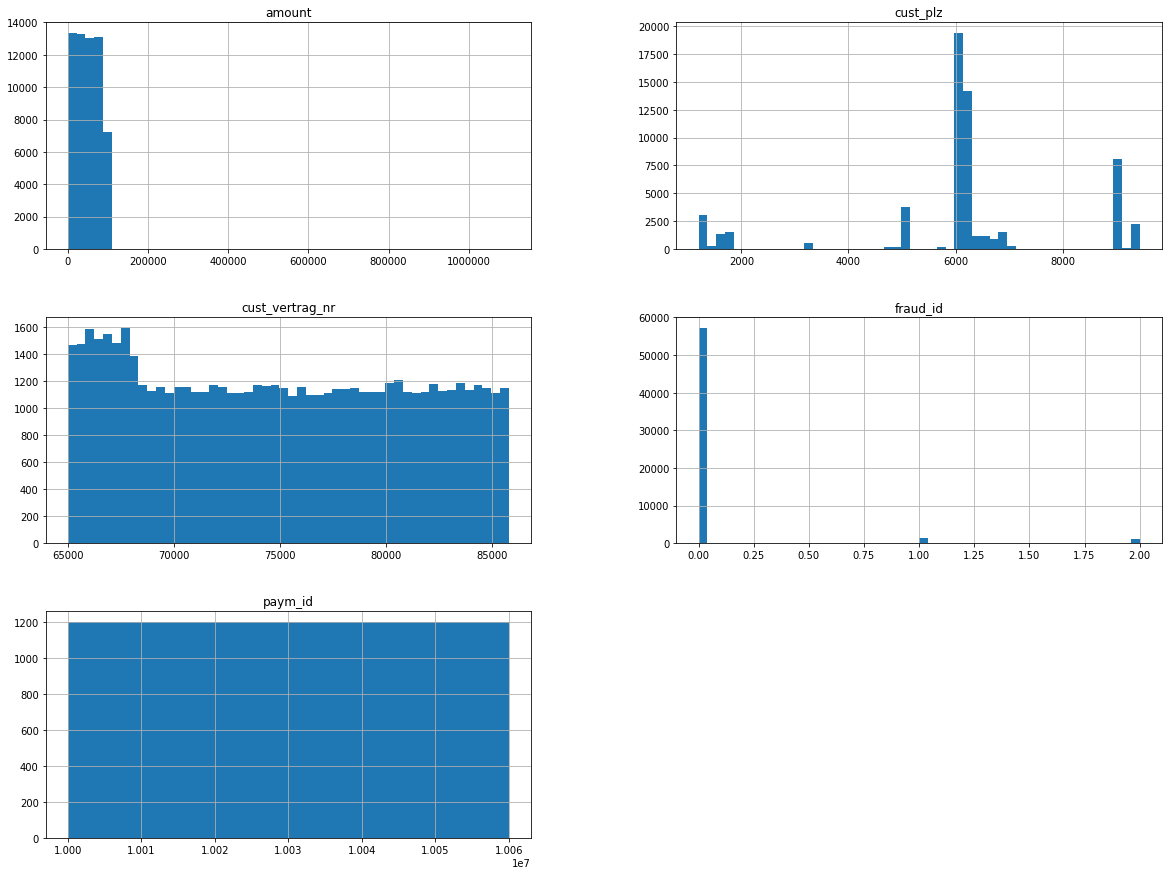

In [0]:
# Visualisierung der Nummerischen Daten in dem Datensatz
trx_data.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# Suche nach den Korrelationen - Teil 1
corr_matrix = trx_data.corr()
print ('Korrelation zu Payment ID','\n',corr_matrix['paym_id'].sort_values(ascending=False))
print ('Korrelation zu Zahlungssumme','\n',corr_matrix['amount'].sort_values(ascending=False))
print ('Korrelation zu Kundenvertrag','\n',corr_matrix['cust_vertrag_nr'].sort_values(ascending=False))
print ('Korrelation zu Betrugsid','\n',corr_matrix['fraud_id'].sort_values(ascending=False))

In [0]:
# Bereinigung der Daten
pd.to_datetime(trx_data['timestamp'])
pd.to_datetime(trx_data['valuta_date'])
np.where(np.isnan(trx_data))

TypeError: ignored

In [0]:
# Datensatz in Trainings(80%)- und Testdatenset (20%) teilen
from sklearn.model_selection import train_test_split
train_trx_data, test_trx_data = train_test_split(trx_data, test_size=0.2, random_state=42) 
train_trx_data.count(), test_trx_data.count()

In [0]:
# Dimensionsreduktion mit PCA
from sklearn.decomposition import PCA # Import der PCA Funktion von Scikit Learn
from sklearn import preprocessing # Die Preprocessing Funktion hilft uns die Daten zu skalieren bevor sie mit PCA verwendet werden.